In [6]:
import arbitragelab as al
import dash
import yfinance as yf

In [7]:
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import pandas as pd
from flask import request

## Data

In [8]:
# Loading data
train_data =  yf.download("GLD GDXJ", start="2016-01-01", end="2018-01-01")
test_data =  yf.download("GLD GDXJ", start="2018-01-02", end="2020-01-01")

# Taking close prices for chosen instruments
train_three_elements = train_data["Adj Close"][["GLD", "GDXJ"]]

test_three_elements = test_data["Adj Close"][["GLD", "GDXJ"]]

# Looking at the downloaded data
train_three_elements.head()

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


,GLD,GDXJ
Date,,
2015-12-31,101.459999,17.784159
2016-01-04,102.889999,18.330364
2016-01-05,103.180000,18.367397
2016-01-06,104.669998,18.682161
2016-01-07,106.150002,19.117277


### ADF

In [2]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [9]:
adf_test(train_three_elements['GLD'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.014962
p-value                          0.033521
#Lags Used                       4.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


In [11]:
adfuller(train_three_elements['GDXJ'], autolag='AIC')

(-2.6073716854664704,
 0.09148324139788433,
 4,
 499,
 {'1%': -3.4435228622952065,
  '5%': -2.867349510566146,
  '10%': -2.569864247011056},
 1410.0891848889364)

In [10]:
adf_test(train_three_elements['GDXJ'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.607372
p-value                          0.091483
#Lags Used                       4.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


### Johansen

In [11]:
# Initialising an object containing needed methods
j_portfolio = al.cointegration_approach.JohansenPortfolio()

# Fitting the data on a dataset of three elements with constant term
j_portfolio.fit(train_three_elements, det_order=0)

# Getting results of the eigenvalue and trace Johansen tests
j_eigenvalue_statistics = j_portfolio.johansen_eigen_statistic
j_trace_statistics = j_portfolio.johansen_trace_statistic
j_cointegration_vectors = j_portfolio.cointegration_vectors



In [12]:
# First, the eigenvalue statistic test
j_eigenvalue_statistics

,GLD,GDXJ
90%,12.2971,2.705500
95%,14.2639,3.841500
99%,18.5200,6.634900
eigen_value,10.2804,2.873192


In [13]:
# Next, the alternative trace statistic test
j_trace_statistics

,GLD,GDXJ
90%,13.429400,2.705500
95%,15.494300,3.841500
99%,19.934900,6.634900
trace_statistic,13.153592,2.873192


In [14]:
# Coefficients to construct a mean-reverting portfolio 
j_cointegration_vectors

,GLD,GDXJ
0,0.184139,0.003739
1,-0.206006,0.235060


### Portfolio calculation

In [15]:
# Weights of elements for the Johansen portfolio
j_cointegration_vectors.loc[0]

GLD     0.184139
GDXJ    0.003739
Name: 0, dtype: float64

In [16]:
# Scaling cointegration vectors so they sum up to 1
j_scaled_vectors = j_cointegration_vectors.loc[0] / abs(j_cointegration_vectors.loc[0]).sum()

j_scaled_vectors

GLD     0.9801
GDXJ    0.0199
Name: 0, dtype: float64

In [17]:
# Also adding weights to take initial prices of our ETFs into account
weights  = train_three_elements.iloc[0] / abs(train_three_elements.iloc[0]).sum()

In [18]:
# Calculating portfolio values during the training period
j_portfolio_returns = (train_three_elements_returns * j_scaled_vectors * weights).sum(axis=1)
j_portfolio_price = (j_portfolio_returns + 1).cumprod()

NameError: name 'train_three_elements_returns' is not defined

In [ ]:
# Plotting Johansen portfolio price
j_portfolio_price.plot(title='Johansen portfolio price', figsize=(10,5));

Another way to construct portfolios is by using the construct_mean_reverting_portfolio function from the JohansenPortfolio or the EngleGrangerPortfolio class. This portfolio is created by summing up price series with given coefficients.

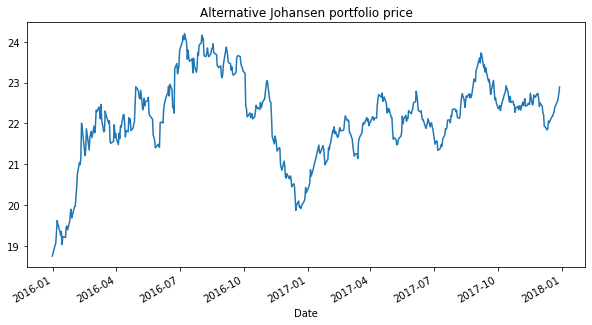

In [19]:
# Alternative way to construct portfolios
alternative_j_portfolio_price = j_portfolio.construct_mean_reverting_portfolio(train_three_elements, j_cointegration_vectors.loc[0])

# Plotting the portfolio price
alternative_j_portfolio_price.plot(title='Alternative Johansen portfolio price', figsize=(10,5));

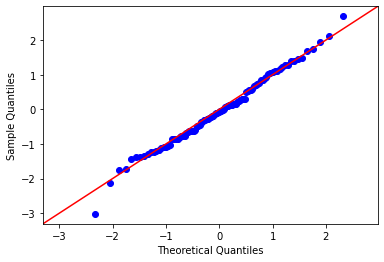

In [20]:
import numpy as np
import statsmodels.api as sm
import pylab as py
  
# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code 
# the graph look different than shown below.
  
# Random data points generated
data_points = np.random.normal(0, 1, 100)    
  
sm.qqplot(data_points, line ='45')
py.show()

In [36]:
? stats.probplot

Signature:
 stats.probplot(
    x,
    sparams=(),
    dist='norm',
    fit=True,
    plot=None,
    rvalue=False,
)
Docstring:
Calculate quantiles for a probability plot, and optionally show the plot.

Generates a probability plot of sample data against the quantiles of a
specified theoretical distribution (the normal distribution by default).
`probplot` optionally calculates a best-fit line for the data and plots the
results using Matplotlib or a given plot function.

Parameters
----------
x : array_like
    Sample/response data from which `probplot` creates the plot.
sparams : tuple, optional
    Distribution-specific shape parameters (shape parameters plus location
    and scale).
dist : str or stats.distributions instance, optional
    Distribution or distribution function name. The default is 'norm' for a
    normal probability plot.  Objects that look enough like a
    stats.distributions instance (i.e. they have a ``ppf`` method) are also
    accepted.
fit : bool, optional
    

# DATA ARBITRAGELAB

Imports

In [372]:
import arbitragelab as al
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import kurtosis, skew, shapiro
from arbitragelab.cointegration_approach import get_half_life_of_mean_reversion
from statsmodels.tsa.stattools import pacf, adfuller, acf

Data raw

In [23]:
# Loading data
train_data =  yf.download("GLD GDXJ", start="2016-01-01", end="2018-01-01")
test_data =  yf.download("GLD GDXJ", start="2018-01-02", end="2020-01-01")

# Taking close prices for chosen instruments
train_three_elements = train_data["Adj Close"][["GLD", "GDXJ"]]

test_three_elements = test_data["Adj Close"][["GLD", "GDXJ"]]

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [24]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return (dftest)

ADF test


 test statistic is less (more negative) than the critical value

In [25]:
first_adf = adfuller(train_three_elements['GLD'], autolag='AIC')

second_adf = adfuller(train_three_elements['GDXJ'], autolag='AIC')

In [320]:
list(adfuller(train_three_elements['GLD'])[4].values())

[-3.4435228622952065, -2.867349510566146, -2.569864247011056]

In [324]:
ass_n=train_three_elements.columns[0]

In [331]:
a = pd.DataFrame(data=train_three_elements[ass_n])
a.columns

Index(['GLD'], dtype='object')

In [332]:
adf

,Confidence level,Value
0,99%,-3.44352
1,95%,-2.86735
2,90%,-2.56986


In [27]:
list(first_adf[4].values())

[-3.4435228622952065, -2.867349510566146, -2.569864247011056]

In [28]:
adf_test(train_three_elements['GDXJ'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.607372
p-value                          0.091483
#Lags Used                       4.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


(-2.6073716854664704,
 0.09148324139788433,
 4,
 499,
 {'1%': -3.4435228622952065,
  '5%': -2.867349510566146,
  '10%': -2.569864247011056},
 1410.0891848889364)

In [352]:
train_three_elements

,GLD,GDXJ
Date,,
2015-12-31,101.459999,17.784159
2016-01-04,102.889999,18.330364
2016-01-05,103.180000,18.367397
2016-01-06,104.669998,18.682161
2016-01-07,106.150002,19.117277
...,...,...
2017-12-22,120.940002,32.702591
2017-12-26,121.769997,33.453594
2017-12-27,122.230003,33.414581


### **Data on Coint-related data**

Engle-Granger

In [354]:
# Initialising an object containing needed methods
eg_portfolio = al.cointegration_approach.EngleGrangerPortfolio()

# Fitting the data on a dataset of three elements with constant term
eg_portfolio.fit(train_three_elements, add_constant=False)

# Getting results of the Engle-Granger test
eg_adf_statistics = eg_portfolio.adf_statistics
eg_cointegration_vectors = eg_portfolio.cointegration_vectors

In [355]:
eg_cointegration_vectors

,GLD,GDXJ
0,1.0,-3.481752


In [300]:
eg_adf_statistics

,0
99%,-3.443523
95%,-2.867350
90%,-2.569864
statistic_value,-2.442489


In [339]:
adf = {'Confidence level':['99%', '95%', '90%']}

# adf['Value'] = eg_adf_statistics[:-1].reset_index()[0].astype(float).round(5)

In [361]:
list(eg_adf_statistics[:-1][0].round(5))

[-3.4435, -2.86734, -2.56986]

In [362]:
eg_adf_statistics[' '] = eg_adf_statistics.index

eg_adf = eg_adf_statistics[:-1]

test_stat = eg_adf_statistics.loc['statistic_value'][0]
test_stat 



-2.2888656100651565

In [89]:
eg_adf_statistics_2[' '] = eg_adf_statistics_2.index

eg_adf_2 = eg_adf_statistics_2[:-1]

eg_adf_2
test_stat_2 = eg_adf_statistics_2.loc['statistic_value'][0]
test_stat_2 

-1.7004577107383319

In [90]:
# Looking at the statistic from the last step of the Engle-Granger test
list(eg_adf_statistics[0])

[-3.44352, -2.86735, -2.56986, -2.442488670394889]

In [91]:
eg_cointegration_vectors


,GLD,GDXJ
0,1.0,-0.630068


In [92]:
# Residuals

res = eg_portfolio.residuals
res

Date
2015-12-31   -8.234267
2016-01-04   -7.148413
2016-01-05   -6.881746
2016-01-06   -5.590071
2016-01-07   -4.384220
                ...   
2017-12-22    1.846107
2017-12-26    2.202918
2017-12-27    2.687506
2017-12-28    3.313647
2017-12-29    4.187392
Name: GLD, Length: 504, dtype: float64

In [258]:
# Q-Q plot data

qq = stats.probplot(eg_portfolio.residuals, dist='norm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

In [94]:
# Initialising an object containing needed methods
eg_portfolio_2 = al.cointegration_approach.EngleGrangerPortfolio()

# Fitting the data on a dataset of three elements with constant term
eg_portfolio_2.fit(train_three_elements[['GDXJ','GLD']], add_constant=True)

# Getting results of the Engle-Granger test
eg_adf_statistics_2 = eg_portfolio_2.adf_statistics
eg_cointegration_vectors_2 = eg_portfolio_2.cointegration_vectors

In [272]:
eg_adf_statistics

,0,
99%,-3.443520,99%
95%,-2.867350,95%
90%,-2.569860,90%
statistic_value,-2.442489,statistic_value


In [96]:
# Looking at the statistic from the last step of the Engle-Granger test
list(eg_adf_statistics_2[0])

[-3.4434175660489905,
 -2.8673031724657454,
 -2.5698395516760275,
 -1.7004577107383319]

In [97]:
eg_cointegration_vectors_2


,GDXJ,GLD
0,1.0,-0.862224


In [257]:
# Residuals

res = eg_portfolio.residuals
res

Date
2015-12-31   -8.234267
2016-01-04   -7.148413
2016-01-05   -6.881746
2016-01-06   -5.590071
2016-01-07   -4.384220
                ...   
2017-12-22    1.846107
2017-12-26    2.202918
2017-12-27    2.687506
2017-12-28    3.313647
2017-12-29    4.187392
Name: GLD, Length: 504, dtype: float64

In [99]:
# Q-Q plot data

qq_2 = stats.probplot(eg_portfolio_2.residuals, dist='norm', sparams=(1))
x_2 = np.array([qq[0][0][0], qq[0][0][-1]])

Johansen

In [100]:
# Initialising an object containing needed methods
j_portfolio = al.cointegration_approach.JohansenPortfolio()

# Fitting the data on a dataset of three elements with constant term
j_portfolio.fit(train_three_elements, det_order=0)

# Getting results of the eigenvalue and trace Johansen tests
j_eigenvalue_statistics = j_portfolio.johansen_eigen_statistic
j_trace_statistics = j_portfolio.johansen_trace_statistic
j_cointegration_vectors = j_portfolio.cointegration_vectors

In [101]:
# First, the eigenvalue statistic test
j_eigenvalue_statistics

,GLD,GDXJ
90%,12.2971,2.705500
95%,14.2639,3.841500
99%,18.5200,6.634900
eigen_value,10.2804,2.873192


In [102]:
# Next, the alternative trace statistic test
j_trace_statistics

,GLD,GDXJ
90%,13.429400,2.705500
95%,15.494300,3.841500
99%,19.934900,6.634900
trace_statistic,13.153592,2.873192


In [103]:
# Coefficients to construct a mean-reverting portfolio 
j_cointegration_vectors

,GLD,GDXJ
0,0.184139,0.003739
1,-0.206006,0.235060


### **Portfolio creation**

In [104]:
# Calculating returns of our elements (ETFs)
train_three_elements_returns = (train_three_elements / train_three_elements.shift(1) - 1)[1:]

train_three_elements_returns.head()

,GLD,GDXJ
Date,,
2016-01-04,0.014094,0.030713
2016-01-05,0.002819,0.002020
2016-01-06,0.014441,0.017137
2016-01-07,0.014140,0.023290
2016-01-08,-0.004428,-0.028571


**Johasen**

In [105]:
# Weights of elements for the Johansen portfolio
j_cointegration_vectors.loc[0]

GLD     0.184139
GDXJ    0.003739
Name: 0, dtype: float64

In [106]:
# Scaling cointegration vectors so they sum up to 1
j_scaled_vectors = j_cointegration_vectors.loc[0] / abs(j_cointegration_vectors.loc[0]).sum()

j_scaled_vectors

GLD     0.9801
GDXJ    0.0199
Name: 0, dtype: float64

In [107]:
# Also adding weights to take initial prices of our ETFs into account
weights  = train_three_elements.iloc[0] / abs(train_three_elements.iloc[0]).sum()

In [108]:
# Also adding weights to take initial prices of our ETFs into account
weights_2  = train_three_elements[['GDXJ','GLD']].iloc[0] / abs(train_three_elements[['GDXJ','GLD']].iloc[0]).sum()

In [109]:
# Calculating portfolio values during the training period
j_portfolio_returns = (train_three_elements_returns * j_scaled_vectors * weights).sum(axis=1)
j_portfolio_price = (j_portfolio_returns + 1).cumprod()

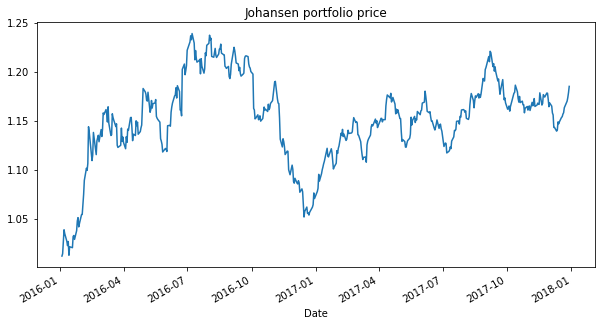

In [110]:
# Plotting Johansen portfolio price
j_portfolio_price.plot(title='Johansen portfolio price', figsize=(10,5));

**Engle-Granger**

In [111]:
# Weights of elements for the Engle-Granger portfolio
eg_cointegration_vectors.loc[0]

GLD     1.000000
GDXJ   -0.630068
Name: 0, dtype: float64

In [112]:
# Scaling weights so they sum up to 1
eg_scaled_vectors = eg_cointegration_vectors.loc[0] / abs(eg_cointegration_vectors.loc[0]).sum()

eg_scaled_vectors

GLD     0.613471
GDXJ   -0.386529
Name: 0, dtype: float64

In [113]:
# Calculating portfolio values during the training period
eg_portfolio_returns = (train_three_elements_returns * eg_scaled_vectors * weights).sum(axis=1)
eg_portfolio_price = (eg_portfolio_returns + 1).cumprod()

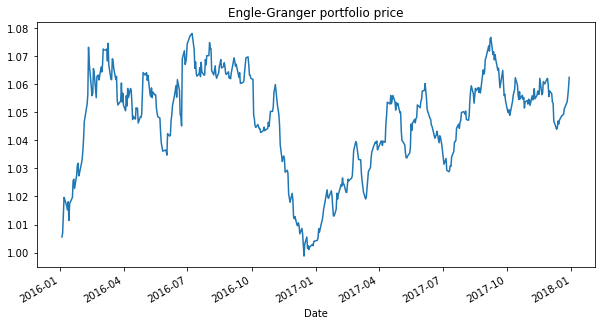

In [114]:
# Plotting Engle-Granger portfolio price
eg_portfolio_price.plot(title='Engle-Granger portfolio price', figsize=(10,5));

In [115]:
# Weights of elements for the Engle-Granger portfolio
eg_cointegration_vectors_2.loc[0]

GDXJ    1.000000
GLD    -0.862224
Name: 0, dtype: float64

In [116]:
# Scaling weights so they sum up to 1
eg_scaled_vectors_2 = eg_cointegration_vectors_2.loc[0] / abs(eg_cointegration_vectors_2.loc[0]).sum()

eg_scaled_vectors_2

GDXJ    0.536992
GLD    -0.463008
Name: 0, dtype: float64

In [117]:
# Calculating portfolio values during the training period
eg_portfolio_returns_2 = (train_three_elements_returns[['GDXJ','GLD']] * eg_scaled_vectors_2 * weights_2).sum(axis=1)
eg_portfolio_price_2 = (eg_portfolio_returns_2 + 1).cumprod()

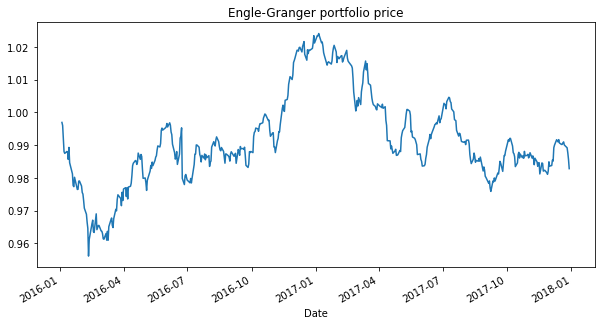

In [118]:
# Plotting Engle-Granger portfolio price
eg_portfolio_price_2.plot(title='Engle-Granger portfolio price', figsize=(10,5));

We can see that these portfolios perform similarly, as relative weights of elements in them are close. Let's compare them if we upscale the weights of the Johansen portfolio to match the weight of the first weight in the Engle-Granger portfolio.

In [119]:
# Scaling Johansen portfolio weights
weights = pd.concat([j_cointegration_vectors.loc[0]*2.459,
                     eg_cointegration_vectors.loc[0]],
                    axis=1,
                    keys = ['Johansen weights', 'Engle-Granger weights'])

weights

,Johansen weights,Engle-Granger weights
GLD,0.452797,1.000000
GDXJ,0.009194,-0.630068


## RESIDUALS DATA

Skewness & Kurtosis

In [262]:
skewn = skew(res)
kurtos = kurtosis(res)

skewn_2 = skew(res_2)
kurtos_2 = kurtosis(res_2)
skewn, kurtos

(-0.7305115393889677, -0.19668952145303908)

In [266]:
res_df = pd.DataFrame(data={'Charachteristic': ['Standard Deviation', 'Half-life', 'Skewness', 'Kurtosis', 'Shapiro-Wilk normality test'], 'Value': [round(std,5), round(eg_res_half_life,5), round(skewn,5), round(kurtos,5), shap]})

In [267]:
res_df_2 = pd.DataFrame(data={'Charachteristic': ['Standard Deviation', 'Half-life', 'Skewness', 'Kurtosis', 'Shapiro-Wilk normality test'], 'Value': [round(std_2,5), round(eg_res_half_life_2,5), round(skewn_2,5), round(kurtos_2,5), shap_2]})

In [268]:
res_df


,Charachteristic,Value
0,Standard Deviation,3.64817
1,Half-life,33.4797
2,Skewness,-0.73051
3,Kurtosis,-0.19669
4,Shapiro-Wilk normality test,Failed


In [263]:
eg_res_half_life = get_half_life_of_mean_reversion(res)
eg_res_half_life_2 = get_half_life_of_mean_reversion(res_2)

In [264]:
std = res.std()
std_2 = res_2.std()

stat

0.9862629771232605

In [265]:
stat, p = shapiro(res)
alpha = 0.05

p,alpha

if p>alpha:
    shap='Passed'
else:
    shap = 'Failed'

In [230]:
stat_2, p_2 = shapiro(res_2)
alpha_2 = 0.05

p_2,alpha

if p_2>alpha:
    shap_2='Passed'
else:
    shap_2 = 'Failed'

In [373]:
PACF = pacf(res, nlags=20)
ACF = acf(res, nlags=20)

D:\programs\Anaconda\envs\arbitragelab\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



In [125]:
import numpy as np
from scipy import stats
import plotly.graph_objects as go

qq = stats.probplot(eg_portfolio.residuals, dist='norm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

# fig = go.Figure()
# fig.add_scatter(x=qq[0][0], y=qq[0][1], mode='markers')
# fig.add_scatter(x=x, y=qq[1][1] + qq[1][0]*x, mode='lines')
# fig.layout.update(showlegend=False)
# fig.show()

In [374]:
res_2 = eg_portfolio_2.residuals

qq_2 = stats.probplot(eg_portfolio_2.residuals, dist='norm', sparams=(1))

x_2 = np.array([qq_2[0][0][0], qq_2[0][0][-1]])

PACF_2 = pacf(res_2, nlags=20)

ACF_2 = acf(res_2, nlags=20)



In [127]:

fig_1 = go.Figure()
fig_1.add_trace(go.Scatter(
    x= np.arange(len(PACF)),
    y= PACF,
    name= 'PACF',
    ))
fig_1.update_xaxes(rangeslider_visible=True)
fig_1.update_layout(
    title="Partial Autocorrelation",
    xaxis_title="Lag",
    yaxis_title="Partial Autocorrelation",
    #     autosize=False,
    #     width=500,
         height=500,
    )

app.layout = html.Div(children=[
    dcc.Graph(
        id='example-graph-2',
        figure=fig_1
        , style={'width':'30%', 
                    'height':'80%',
                    'margin-top': 0,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                }),


])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


### **Compiled data**

In [ ]:
residuals_data = {'skewness':skew, 'kurtosis':kurtosis, 'half-life':eg_res_half_life, 'standard deviation':std, 'normality p':p}

In [346]:
confidence_levels = ['Confidence level',['99%', '95%', '90%']]

In [349]:
data = {confidence_levels[0]:confidence_levels[1]}

NameError: name 'confidence_level' is not defined

In [ ]:
eg_portfolio_price.index

# VISUALS PLOTLY

Imports

In [50]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

fig = go.Figure()
fig.add_trace(go.Scatter(x=eg_portfolio_price.index, y=eg_portfolio_price,
                    mode='lines', line=dict(color='darkturquoise')))
fig.update_layout(
    title="GLD/GDXJ portfolio price",
    xaxis_title="Date",
    yaxis_title="Price",
    
    #     autosize=False,
    #     width=500,
         height=500,
    )

fig.update_xaxes(rangeslider_visible=True)

app.layout = html.Div(children=[
    
    
     dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'90%', 
                    'height':'90%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                })  

    
    
])

if __name__ == '__main__':
    app.run_server()

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

df_pacf = PACF
fig = go.Figure()
fig.add_trace(go.Scatter(
    x= np.arange(len(df_pacf)),
    y= df_pacf,
    name= 'PACF',
    ))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title="Partial Autocorrelation",
    xaxis_title="Lag",
    yaxis_title="Partial Autocorrelation",
    #     autosize=False,
    #     width=500,
         height=500,
    )

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    
    dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'90%', 
                    'height':'90%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                })  
    
    
])

if __name__ == '__main__':
    app.run_server()

## **PACF**

In [270]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

trace2 = {
  "name": "pacf", 
  "type": "bar", 
  "y": PACF
}

fig = go.Figure(data=trace2)

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    
    dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'40%', 
                    'height':'90%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                })  
])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Apr/2021 09:35:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 09:35:10] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_0m1617880301.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 09:35:10] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_0m1617880301.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 09:35:10] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_0m1617880301.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 09:35:10] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_0m1617880301.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 09:35:10] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_1_2m1617880302.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 09:35:10] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.v1_15_0m1617880302.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 09

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    
    
])

if __name__ == '__main__':
    app.run_server()

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    
    
])

if __name__ == '__main__':
    app.run_server()

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    
    
])

if __name__ == '__main__':
    app.run_server()

# VISUALS DASH

Imports

In [70]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from flask import request
import dash_table

In [52]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options

fig =  go.Figure()
fig.add_scatter(x=qq[0][0], y=qq[0][1], mode='markers')
fig.add_scatter(x=x, y=qq[1][1] + qq[1][0]*x, mode='lines')
fig.layout.update(showlegend=False)




app.layout = html.Div(children=[
    html.Div(children=[
        html.Img(src='/assets/LB_Hudson_Thames_ProductLogos_ArbitrageLab-01.png', 
             style={'width':'15%', 
                    'height':'15%',
                    'margin-bottom': 30,
                    'margin-left': 30, 
                    'vertical-align': 'top', 
                    'horizontal-align': 'left',
                    'display':'inline-block'
                   }),

        html.H1(children='Hello Dash',
                style={'padding-bottom': '1%',
                       'vertical-align': 'bottom', 
                       'horizontal-align': 'right',
                       'display':'inline-block'
                   })]),

    html.Div(children='''
        Q-Q PLOT.
        ''',
             style={'font-family':'Josefin Sans', 
                    'font-weight':'300',
                    'font-size': 30,
                    'margin-left': 70, 
                    'align': 'center',
#                     'display':'inline-block'
                    
                }),

    dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'30%', 
                    'height':'80%',
                    'margin-top': 0,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
                    'display':'inline-block'
                }),
    dcc.Graph(
        id='example-graph-2',
        figure=fig_1
        , style={'width':'30%', 
                    'height':'80%',
                    'margin-top': 0,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                }),


])

if __name__ == '__main__':
    app.run_server()

NameError: name 'fig_1' is not defined

In [99]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_three_elements.index, y=train_three_elements['GLD'],
                    mode='lines', line=dict(color='darkturquoise')))
fig.update_layout(
    title="GLD/GDXJ portfolio price",
    xaxis_title="Date",
    yaxis_title="Price",
    #     autosize=False,
    #     width=500,
         height=500,
    )

fig.update_xaxes(rangeslider_visible=True)

app.layout = html.Div(children=[
    
    
     dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'90%', 
                    'height':'90%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                })  

    
    
])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [71]:
norm_GLD = (train_three_elements['GLD'] - train_three_elements['GLD'].min())/(train_three_elements['GLD'].max()-train_three_elements['GLD'].min())
norm_GDXJ = (train_three_elements['GDXJ'] - train_three_elements['GDXJ'].min())/(train_three_elements['GDXJ'].max()-train_three_elements['GDXJ'].min())

In [ ]:
height: auto;

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


blue = '#0C9AAC'
orange = '#DE612F'
grey = '#949494'
light_grey = '#F2F3F4'
black = '#0B0D13'
white = '#ffffff'
oxford_blue = '#072040'
colors = {
    'background': light_grey,
    'text': black,
    'highlight': blue,
    'white': white,
    'orange': orange
}

asset_prices = go.Figure()
asset_prices.add_trace(go.Scatter(x=train_three_elements.index, y=norm_GLD,
                    mode='lines', line=dict(color=blue), name='GLD'))
asset_prices.add_trace(go.Scatter(x=train_three_elements.index, y=norm_GDXJ,
                    mode='lines', line=dict(color=orange), name='GDXJ'))
asset_prices.update_layout(
    legend=dict(
    yanchor="top",
    y=0.97,
    xanchor="left",
    x=0.925),
    title="Asset prices",
    xaxis_title="Date",
    yaxis_title="Price",
    font_family='Josefin Sans', 
    font_size=18,
    #     autosize=False,
    #     width=500,
    height=500,
    hovermode='x unified'
    )



asset_prices.update_xaxes(rangeslider_visible=True)


app = dash.Dash()


app.layout = html.Div(style={'backgroundColor': colors['background'], 'padding-bottom': 30}, children=[
    
    html.Img(src='/assets/LB_Hudson_Thames_ProductLogos_ArbitrageLab-13.png', 
         style={'width':'20%', 
                'height':'20%',
                'padding-top': 50,                
                'display': 'block',
                'margin-left': 'auto',
                'margin-right': 'auto'
               }),

    html.H1(
        children='COINTEGRATION ANALYSIS OF GLD/GDXJ',
        style={
            'textAlign': 'center',
            'color': colors['text'],
            'font-family':'Josefin Sans', 
            'font-weight':'300',
            'font-size': 50,
            'padding-top': 30,
            'padding-left': 50,
            'margin-top': 30,
            'margin-left': 'auto',
            'margin-right': 'auto'
        }
    ),
    
   # INITIAL DIV 
    html.Div(style={'margin-left': '5%', 'margin-right': '5%',
                    'margin-top': '5%', 'margin-bottom': '5%',  
                    'backgroundColor': colors['white'],
                    'horizontal-align': 'center'}, children=[
        
        html.Div(style={'backgroundColor': colors['white'],
                    'display':'inline-block', 'padding-left': 30,
                    'padding-right': 50, 'padding-top': 60,
                    'padding-bottom': 50, 'margin-left': 50,
                    'margin-right': 50, 'margin-top': 0,
                    'margin-bottom': 50, 'vertical-align':'center', 
                    'horizontal-align': 'center', 'height': 315, 'width': '20%'}, children=[        
        
            html.H2(
            children='The results of the ADF tests:',
            style={
                'textAlign': 'left',
                'color': colors['text'],
                'font-family':'Josefin Sans', 
                'font-weight':'500',
                'font-size': 24,
                'padding-bottom': '20%',
            }
            ),

            html.P(
            children='GLD',
            style={
                'textAlign': 'left',
                'color': colors['highlight'],
                'font-family':'Josefin Sans', 
                'font-weight':'500',
                'font-size': 20

            }),


            html.P(
            children='The hypothesis is not rejected at 95% confidence level',
            style={
                'textAlign': 'left',
                'color': colors['text'],
                'font-family':'Roboto', 
                'font-weight':'300',
                'font-size': 18

            }),

            html.P(
            children='GDXJ',
            style={
                'textAlign': 'left',
                'color': colors['highlight'],
                'font-family':'Josefin Sans', 
                'font-weight':'500',
                'font-size': 20

            }),


            html.P(
            children='The hypothesis is not rejected at 90% confidence level',
            style={
                'textAlign': 'left',
                'color': colors['text'],
                'font-family':'Roboto', 
                'font-weight':'300',
                'font-size': 18

            }),


        ]),
    
    dcc.Graph(
        id='example-graph',
        figure=asset_prices
        , style={'width': '60%', 
                 'height': '100%',
                 'padding-left': 50,
                 #'padding-right': 50,
                 'padding-top': 50,
                 'padding-bottom': 30, 
                 #'margin-right': 50, 
                 'margin-top': 0,
                 'margin-bottom': 0, 'vertical-align':'top', 
                 'horizontal-align': 'right',
                 'display':'inline-block',
                 'font-family':'Josefin Sans', 
                 'font-weight':'300',
                 'font-size': 24,
             
                })
        
        
    ]),
    
    
    html.Div(style={'margin-left': '5%', 'margin-right': '5%',
                    'margin-top': '5%', 'margin-bottom': '5%', 
#                     'margin-left': '1%',
#                     'margin-right': '0%', 'margin-top': '1%',
#                     'margin-bottom': '1%', 
                    'backgroundColor': colors['white'],
                    'horizontal-align': 'center'}, children=[
        
        
            html.H2(
                children='ENGLE-GRANGER APPROACH',
                style={
                    'textAlign': 'left',
                    'color': colors['text'],
                    'font-family':'Josefin Sans', 
                    'font-weight':'300',
                    'font-size': 40,
                    'padding-left': 50,
                    'padding-right': 50,
                    'padding-top': 60,
                    'padding-bottom': 0,
                    'margin-left': 50,
                    'margin-right': 50,
                    'margin-top': 0,
                    'margin-bottom': 0,
                    
                }
            ),         
            
            html.Div(style={'display':'block',
                            'padding-left': 50,
                            'padding-right': 50,
                            'padding-top': 60,
                            'padding-bottom': 0,
                            'margin-left': 50,
                            'margin-right': 50,
                            'margin-top': 0,
                            'margin-bottom': 0,
                            'vertical-align':'center',
                            'horizontal-align': 'right'}, children=[               
                
                html.Button('GLD/GDXJ', id='btn-nclicks-1', n_clicks=0, style={'BackgroundColor': colors['white'], 'padding-left': 40,
                                                                               'padding-right': 40, 'padding-top': 20,
                                                                               'padding-bottom': 20, 'margin-left': 0,
                                                                               'margin-right': 25, 'margin-top': 0,
                                                                               'margin-bottom': 0, 'font-family':'Josefin Sans',
                                                                               'font-weight':'300', 'font-size': 20,
                                                                              }),
                
                html.Button('GDXJ/GLD', id='btn-nclicks-2', n_clicks=0, style={'BackgroundColor': colors['white'], 'padding-left': 40,
                                                                               'padding-right': 40, 'padding-top': 20,
                                                                               'padding-bottom': 20, 'margin-left': 25,
                                                                               'margin-right': 40, 'margin-top': 0,
                                                                               'margin-bottom': 0, 'font-family':'Josefin Sans',
                                                                               'font-weight':'300', 'font-size': 20,
                                                                              }),
            ]),
                
            
            
                
            html.Div(id='container-button'),
              
    ])
])

@app.callback(Output('container-button', 'children'),
              Input('btn-nclicks-1', 'n_clicks'),
              Input('btn-nclicks-2', 'n_clicks'))

def displayClick(btn1, btn2):
    changed_id = [p['prop_id'] for p in dash.callback_context.triggered][0]
    if 'btn-nclicks-1' in changed_id:
        asset_1 = 'GLD'
        asset_2 = 'GDXJ'
        coint_test = eg_adf
        test_statistic = test_stat
        beta = eg_cointegration_vectors.loc[0][1]
        portfolio_price = eg_portfolio_price
        portfolio_return = eg_portfolio_returns
        pacf = PACF
        acf = ACF
        residuals = res
        qq_data = qq
        x_data = x
        res_data = res_df
        
    elif 'btn-nclicks-2' in changed_id:
        asset_1 = 'GDXJ'
        asset_2 = 'GLD'
        coint_test = eg_adf_2
        test_statistic = test_stat_2
        beta = eg_cointegration_vectors_2.loc[0][1]
        portfolio_price = eg_portfolio_price_2
        portfolio_return = eg_portfolio_returns_2
        pacf = PACF_2
        acf = ACF_2
        residuals = res_2
        qq_data = qq_2
        x_data = x_2
        res_data = res_df_2
        
    else:
        asset_1 = 'GLD'
        asset_2 = 'GDXJ'
        coint_test = eg_adf
        test_statistic = test_stat
        beta = eg_cointegration_vectors.loc[0][1]
        portfolio_price = eg_portfolio_price
        portfolio_return = eg_portfolio_returns
        pacf = PACF
        acf = ACF
        residuals = res
        qq_data = qq
        x_data = x
        res_data = res_df
    
    
    portfolio = go.Figure()
    portfolio.add_trace(go.Scatter(x=portfolio_price.index, y=portfolio_price,
                    mode='lines', line=dict(color=blue), name='Portfolio price'))
    portfolio.add_trace(go.Scatter(x=portfolio_return.index, y=portfolio_return,
                    mode='lines', line=dict(color=orange), name='Portfolio return', visible='legendonly'))
    portfolio.update_layout(
        legend=dict(
        yanchor="top",
        y=0.97,
        xanchor="left",
        x=0.77),
        title="Normalized portfolio",
        xaxis_title="Date",
        yaxis_title="Price",
        font_family='Josefin Sans', 
        font_size=18,
        height=500,
        )
    portfolio.update_xaxes(rangeslider_visible=True)
    
    trace = {
        "name": "PACF", 
        "type": "bar",
        "marker_color": blue,
        "y": pacf
        
    }
    
    _pacf_plot = go.Figure(data=trace)
    
    _pacf_plot.update_layout(
        title="PACF",
        xaxis_title="Lag",
        #yaxis_title="Price",
        font_family='Josefin Sans', 
        font_size=14,
        height = 250,
        margin=dict(l=30, r=30, t=50, b=30))
    
    trace = {
        "name": "ACF", 
        "type": "bar",
        "marker_color": blue,
        "y": acf
        
    }
    
    _acf_plot = go.Figure(data=trace)
    
    _acf_plot.update_layout(
        title="ACF",
        xaxis_title="Lag",
        #yaxis_title="Price",
        font_family='Josefin Sans', 
        font_size=14,
        height = 250,
        margin=dict(l=30, r=30, t=50, b=30))
    
    resid_plot = go.Figure()
    resid_plot.add_trace(go.Scatter(x=residuals.index, y=residuals,
                    mode='lines', line=dict(color=orange)))
    resid_plot.add_shape(type='line',
                         x0='2015-12-31', y0=0, x1='2017-12-29', y1=0, 
                         line=dict(color=grey, dash='dash'))
    resid_plot.update_layout(
        title="Residuals plot",
        font_family='Josefin Sans', 
        font_size=14,
        height = 250,
        margin=dict(l=30, r=30, t=50, b=30)
        )
    
    _qq_plot =  go.Figure()
    _qq_plot.add_scatter(x=qq_data[0][0], y=qq_data[0][1], mode='markers', line=dict(color=blue))
    _qq_plot.add_scatter(x=x, y=qq_data[1][1] + qq_data[1][0]*x_data, mode='lines', line=dict(color=grey))
    _qq_plot.update_layout(
            title="Q-Q Plot",
        font_family='Josefin Sans', 
        font_size=14,
        height = 550,
        margin=dict(l=30, r=30, t=50, b=30),
        showlegend=False
        )
    
        
    
    return html.Div(style={'padding-left': 50,
                            'padding-right': 0,
                            'padding-top': 20,
                            'padding-bottom': 50,
                            'margin-left': 50,
                            'margin-right': 0,
                            'margin-top': 0,
                            'margin-bottom': 0,
                            'backgroundColor': colors['white'],
                            'horizontal-align': 'center', 
                             }, children=[
        # Equation
        html.Div(style={'backgroundColor': colors['white'],
                        'padding-top': 30,
                        'textAlign':'left', 
                        'horizontal-align':'center'}, children=[
                 
                 html.H2(children='{} ='.format(asset_1),
                    style={'textAlign': 'left',
                           'color': colors['text'],
                           'font-family':'Josefin Sans', 
                           'font-weight':'300',
                           'font-size': 30,
                           'padding-bottom': 30,
                           'display':'inline-block'
                          }
                    ),
            
                html.H2(children='⠀{}⠀'.format(round(beta,4)),
                        style={'textAlign': 'left',
                               'color': colors['highlight'],
                               'font-family':'Josefin Sans', 
                               'font-weight':'400',
                               'font-size': 30,
                               'padding-bottom': 30,
                               'display':'inline-block'
                              }
                        ),

                html.H2(children='* {} + ε(t)'.format(asset_2),
                        style={'textAlign': 'left',
                               'color': colors['text'],
                               'font-family':'Josefin Sans', 
                               'font-weight':'300',
                               'font-size': 30,
                               'padding-bottom': 30,
                               'display':'inline-block'
                              }
                        ),
                 
             ]),
        
        # Coint tests
        html.Div(children=[
        
            html.Div(style={'backgroundColor': colors['white'],
                        'display':'inline-block', 'padding-left': 0,
                        'padding-right': 50, 'padding-top': 0,
                        'padding-bottom': 0, 'margin-left': 0,
                        'margin-right': 10, 'margin-top': 0,
                        'margin-bottom': 0, 'vertical-align':'center', 
                        'horizontal-align': 'center', 'width': '22%'}, children=[ 


                      html.H3(children='Cointegration test results:',
                              style={'textAlign': 'left',
                                       'color': colors['text'],
                                       'font-family':'Josefin Sans', 
                                       'font-weight':'500',
                                       'font-size': 22,
                                       'padding-bottom': '2%',
                                       'display':'block'
                                      }
                                ),
                      html.P(children='HYPOTHESIS REJECTED',
                            style={'textAlign': 'left',
                                   'color': colors['orange'],
                                   'font-family':'Josefin Sans', 
                                   'font-weight':'350',
                                   'font-size': 20,
                                   'padding-bottom': '15%',
                                   'padding-top': 0,
                                   'display':'block'
                                  }
                            ),

                      dash_table.DataTable(
                      data=coint_test.to_dict('records'),
                        columns=[{'id': c, 'name': c} for c in coint_test.columns],
                        style_as_list_view=True,

                        style_cell={'padding': '10px', 
                                    'backgroundColor': 'white',
                                    'fontSize': 14,
                                    'font-family':'Roboto'},

                        style_header={'backgroundColor': 'white',
                                        'fontWeight': 'bold',
                                        'fontSize': 14,
                                        'font-family':'Josefin Sans'

                        },),


                      html.Div(style={'display':'block'},children=[

                                  html.P(
                                    children='Test statistic value: ',
                                    style={'textAlign': 'left',
                                           'color': colors['text'],
                                           'font-family':'Josefin Sans', 
                                           'font-weight':'400',
                                           'font-size': 18,
                                           'padding-bottom': '10%',
                                           'display':'inline-block'
                                          }
                                    ),

                                 html.P(children='⠀{}⠀'.format(round(test_statistic,5)),
                                        style={'textAlign': 'center',
                                               'color': colors['highlight'],
                                               'font-family':'Josefin Sans', 
                                               'font-weight':'400',
                                               'font-size': 18,
                                               'padding-bottom': '10%',
                                               'display':'inline-block'
                                              }
                                        ),

                                  ]),


                  ]),

                  dcc.Graph(
                      id='example-graph-3',
                      figure=portfolio,
                      style={'width': '68%', 
                     'height': '100%',
                     'padding-left': 50,
                     #'padding-right': 50,
                     'padding-top': 0,
                     'padding-bottom': 50, 
                     #'margin-right': 50, 
                     'margin-top': 0,
                     'margin-bottom': 0, 'vertical-align':'top', 
                     'horizontal-align': 'right',
                     'display':'inline-block',
                     'font-family':'Josefin Sans', 
                     'font-weight':'300',
                     'font-size': 20,})                                          
        
        ]),
        
        # Coint tests
        html.Div(id='resid',children=[
            
            html.Div(style={'backgroundColor': colors['white'],
                        'display':'inline-block', 'padding-left': 0,
                        'padding-right': 0, 'padding-top': 0,
                        'padding-bottom': 0, 'margin-left': 0,
                        'margin-right': 0, 'margin-top': 0,
                        'margin-bottom': 0, 'vertical-align':'center', 
                        'horizontal-align': 'center', 'width': '100%'}, children=[ 


                      html.H3(children='Residuals analysis results:',
                              style={'textAlign': 'left',
                                       'color': colors['text'],
                                       'font-family':'Josefin Sans', 
                                       'font-weight':'500',
                                       'font-size': 22,
                                       'padding-bottom': '2%',
                                       'display':'block'
                                      }
                                ),
                html.Div(style={'backgroundColor': colors['white'],
                        'display':'inline-block', 'padding-left': 0,
                        'padding-right': 20, 'padding-top': 0,
                        'padding-bottom': 0, 'margin-left': 0,
                        'margin-right': 0, 'margin-top': 0,
                        'margin-bottom': 0, 'vertical-align':'top', 
                        'horizontal-align': 'center', 'width': '30%'}, children=[ 
                    
                 dash_table.DataTable(
                      data=res_data.to_dict('records'),
                        columns=[{'id': c, 'name': c} for c in res_data.columns],
                        style_as_list_view=True,

                        style_cell={'padding': '10px', 
                                    'backgroundColor': 'white',
                                    'fontSize': 14,
                                    'font-family':'Roboto',
                                    'textAlign':'left'},

                        style_header={'padding': '15px',
                                      'backgroundColor': colors['background'],
                                      'fontSize': 18,
                                      'font-family':'Josefin Sans',
                                      'textAlign':'left'

                        }),
                    
                 dcc.Graph(
                          id='example-graph-9',
                          figure=resid_plot,
                          style={'width': '100%', 
                         'height': '100%',
                         'padding-left': 0,
                         #'padding-right': 50,
                         'padding-top': 50,
                         'padding-bottom': 0, 
                         #'margin-right': 50, 
                         'margin-top': 0,
                         'margin-bottom': 0, 'vertical-align':'top', 
                         'horizontal-align': 'right',
                         'display':'block',
                         'font-family':'Josefin Sans', 
                         'font-weight':'300',
                         'font-size': 20,}),
                
                ]),
                
                
                html.Div(style={'backgroundColor': colors['white'],
                        'display':'inline-block', 'width': '30%', 'vertical-align':'center', 
                        'horizontal-align': 'center',},children=[
                    
                      dcc.Graph(
                          id='example-graph-4',
                          figure=_pacf_plot,
                          style={'width': '100%', 
                         'height': '100%',
                         'padding-left': 0,
                         #'padding-right': 50,
                         'padding-top': 0,
                         'padding-bottom': 50, 
                         #'margin-right': 50, 
                         'margin-top': 0,
                         'margin-bottom': 0, 'vertical-align':'top', 
                         'horizontal-align': 'right',
                         'display':'block',
                         'font-family':'Josefin Sans', 
                         'font-weight':'300',
                         'font-size': 20,}),
                
                      dcc.Graph(
                          id='example-graph-5',
                          figure=_acf_plot,
                          style={'width': '100%', 
                         'height': '100%',
                         'padding-left': 0,
                         #'padding-right': 50,
                         'padding-top': 0,
                         'padding-bottom': 50, 
                         #'margin-right': 50, 
                         'margin-top': 0,
                         'margin-bottom': 0, 'vertical-align':'top', 
                         'horizontal-align': 'right',
                         'display':'block',
                         'font-family':'Josefin Sans', 
                         'font-weight':'300',
                         'font-size': 20,}),
                ]),
                
                html.Div(style={'backgroundColor': colors['white'],
                        'display':'inline-block', 'padding-left': 0,
                        'padding-right': 0, 'padding-top': 0,
                        'padding-bottom': 0, 'margin-left': 0,
                        'margin-right': 0, 'margin-top': 0,
                        'margin-bottom': 0, 'vertical-align':'center', 
                        'horizontal-align': 'center', 'width': '30%'}, children=[ 
                    
                 dcc.Graph(
                          id='example-graph-6',
                          figure=_qq_plot,
                          style={'width': '100%', 
                         'height': '100%',
                         'padding-left': 10,
                         #'padding-right': 50,
                         'padding-top': 0,
                         'padding-bottom': 50, 
                         #'margin-right': 50, 
                         'margin-top': 0,
                         'margin-bottom': 0, 'vertical-align':'top', 
                         'horizontal-align': 'right',
                         'display':'block',
                         'font-family':'Josefin Sans', 
                         'font-weight':'300',
                         'font-size': 20,}),
                
                 
                ]),
                
                
            
            ]), 
            
            
            
            
            
        ]),
        
    
   ])
        
        
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


In [244]:
            
#             html.Div(style={'padding-top': 0,
#                             'padding-left': 50,
#                             'margin-top': 0,
#                             'margin-left': 'auto',
#                             'margin-right': 'auto',
#                             'backgroundColor': colors['white'],
#                             'horizontal-align': 'center'}, children=[
        
#         html.Div(style={'backgroundColor': colors['white'],
#                                 'display':'inline-block', 'padding-left': 0,
#                                 'padding-right': 0, 'padding-top': 50,
#                                 'padding-bottom': '6%', 'margin-left': 0,
#                                 'margin-right': 0, 'margin-top': 50,
#                                 'margin-bottom': 50, 'vertical-align':'center', 
#                                 'horizontal-align': 'center', 'height': 315}, children=[ 
                    
                    
#                     html.H2(
#                         children='{} = {} * {} + ε(t)'.format('GLD',
#                                                                eg_cointegration_vectors.loc[0][1], 
#                                                               'GDXJ'),
#                         style={'textAlign': 'left',
#                                'color': colors['text'],
#                                'font-family':'Josefin Sans', 
#                                'font-weight':'500',
#                                'font-size': 26,
#                                'padding-bottom': '20%',
#                               }
#                     ),

#                     html.P(
#                     children='GLD',
#                     style={'textAlign': 'left',
#                            'color': colors['highlight'],
#                            'font-family':'Josefin Sans', 
#                            'font-weight':'500',
#                            'font-size': 24,
#                           }
#                     ),


#                     html.P(
#                     children='The hypothesis is not rejected at 95% confidence level',
#                     style={'textAlign': 'left',
#                            'color': colors['text'],
#                            'font-family':'Roboto', 
#                            'font-weight':'300',
#                            'font-size': 24,
#                            }
#                     ),

#                     html.P(
#                     children='GDXJ',
#                     style={'textAlign': 'left',
#                            'color': colors['highlight'],
#                            'font-family':'Josefin Sans', 
#                            'font-weight':'500',
#                            'font-size': 24,
#                           }
#                     ),


#                     html.P(
#                     children='The hypothesis is not rejected at 90% confidence level',
#                     style={'textAlign': 'left',
#                            'color': colors['text'],
#                            'font-family':'Roboto', 
#                            'font-weight':'300',
#                            'font-size': 24,
#                           }
#                     ),


#                 ]), 
#             ]),
                
                
  

Date
2015-12-31   -0.006846
2016-01-04   -0.693621
2016-01-05   -0.906633
2016-01-06   -1.876581
2016-01-07   -2.717559
                ...   
2017-12-22   -1.884535
2017-12-26   -1.849172
2017-12-27   -2.284814
2017-12-28   -2.829142
2017-12-29   -3.635963
Name: GDXJ, Length: 504, dtype: float64

In [255]:
res_2

Date
2015-12-31   -0.006846
2016-01-04   -0.693621
2016-01-05   -0.906633
2016-01-06   -1.876581
2016-01-07   -2.717559
                ...   
2017-12-22   -1.884535
2017-12-26   -1.849172
2017-12-27   -2.284814
2017-12-28   -2.829142
2017-12-29   -3.635963
Name: GDXJ, Length: 504, dtype: float64

In [156]:
eg_adf_statistics[' '] = eg_adf_statistics.index

eg_adf = eg_adf_statistics[:-1]


In [76]:
eg_adf_statistics_2[' '] = eg_adf_statistics_2.index

eg_adf_2 = eg_adf_statistics_2[:-1]


In [86]:
# Weights of elements for the Engle-Granger portfolio
eg_cointegration_vectors.loc[0][1]

-0.6300681663889197

In [368]:
eg_adf=eg_adf.set_axis(['Value', 'Significance level'], axis=1, inplace=False)
eg_adf = eg_adf
eg_adf['Value'] = eg_adf['Value'].round(decimals=5)
eg_adf = eg_adf
eg_adf

,Value,Significance level
99%,-3.44350,99%
95%,-2.86734,95%
90%,-2.56986,90%


In [366]:
eg_adf_2=eg_adf_2.set_axis(['Value', 'Significance level'], axis=1, inplace=False)
eg_adf_2 = eg_adf_2
eg_adf_2['Value'] = round(eg_adf_2['Value'],5)
eg_adf_2 = eg_adf_2
eg_adf_2

,Value,Significance level
99%,-3.44342,99%
95%,-2.86730,95%
90%,-2.56984,90%


In [315]:
# Scaling weights so they sum up to 1
eg_scaled_vectors = eg_cointegration_vectors.loc[0] / abs(eg_cointegration_vectors.loc[0]).sum()

eg_scaled_vectors

GLD     0.613471
GDXJ   -0.386529
Name: 0, dtype: float64

In [104]:
# Calculating portfolio values during the training period
eg_portfolio_returns = (train_three_elements_returns * eg_scaled_vectors * weights).sum(axis=1)
eg_portfolio_price = (eg_portfolio_returns + 1).cumprod()

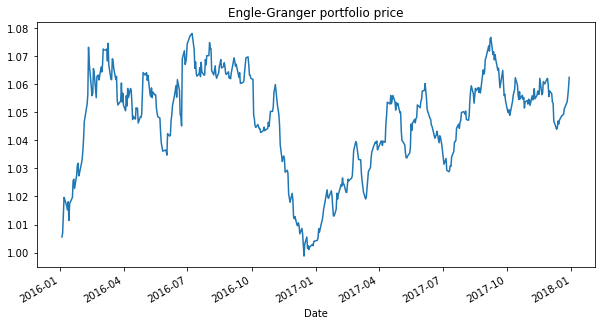

In [105]:
# Plotting Engle-Granger portfolio price
eg_portfolio_price.plot(title='Engle-Granger portfolio price', figsize=(10,5));

In [143]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

fig = go.Figure()
fig.add_trace(go.Scatter(x=eg_portfolio_price.index, y=eg_portfolio_price,
                    mode='lines', line=dict(color='darkturquoise')))
fig.update_layout(
    title="GLD/GDXJ portfolio price",
    xaxis_title="Date",
    yaxis_title="Price",
    #     autosize=False,
    #     width=500,
         height=500,
    )

fig.update_xaxes(rangeslider_visible=True)

app.layout = html.Div(children=[
    
    
     dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'90%', 
                    'height':'90%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                })  

    
    
])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [142]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

fig = go.Figure()
fig.add_trace(go.Scatter(x=eg_portfolio_price.index, y=eg_portfolio_price,
                    mode='lines', line=dict(color='darkturquoise')))
fig.update_layout(
    title="GLD/GDXJ portfolio price",
    xaxis_title="Date",
    yaxis_title="Price",
    #     autosize=False,
    #     width=500,
         height=500,
    )

fig.update_xaxes(rangeslider_visible=True)

app.layout = html.Div(children=[
    
    
     dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'90%', 
                    'height':'90%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                })  

    
    
])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [130]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

fig = go.Figure()
fig.add_trace(go.Scatter(x=eg_portfolio_price.index, y=eg_portfolio_price,
                    mode='lines', line=dict(color='darkturquoise')))
fig.update_layout(
    title="GLD/GDXJ portfolio price",
    xaxis_title="Date",
    yaxis_title="Price",
    #     autosize=False,
    #     width=500,
         height=500,
    )

fig.update_xaxes(rangeslider_visible=True)

app.layout = html.Div(children=[
    
    
     dcc.Graph(
        id='example-graph',
        figure=fig
        , style={'width':'90%', 
                    'height':'90%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
#                     'vertical-align': 'top', 
                    'horizontal-align': 'left',
#                     'display':'inline-block'
                })  

    
    
])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


### Add stylized logo

In [379]:
app = dash.Dash(__name__)

app.layout = html.Div(
    html.Img(src='assets/LB_Hudson_Thames_ProductLogos_ArbitrageLab-01.png', 
             style={'width':'11%', 
                    'height':'11%',
                    'margin-top': 30,
                    'margin-rigt': 30, 
                    'vertical-align': 'top', 
                    'horizontal-align': 'right',
                    'display':'inline-block'}))

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Apr/2021 22:28:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:20] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:20] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:20] "GET /assets/LB_Hudson_Thames_ProductLogos_ArbitrageLab-01.png HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:30] "GET /_dash-component-suites/dash_table/bundle.v4_11_2m1617880301.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:30] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_0m1617880301.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:30] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_0m1617880301.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2021 22:28:30] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_1_2m1617880302.min.js HTTP/1.1" 200 -
127.0.0.

## Color
Munsell #0C9AAC

Flame #DE612F

Black #0B0D13

Blue #072040

Grey dark #949494

Grey light #F2F3F4

In [ ]:
! pip install dash-bootstrap-components


In [ ]:
# import required packages
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import plotly.graph_objs as go
import numpy as np
import pandas as pd


# define figure creation function
def create_figure():
    N = 100
    x_min = 0
    x_max = 10
    y_min = 0
    y_max = 10

    blue = '#6683f3'
    orange = '#ff9266'
    grey = '#e0e1f5'
    black = '#212121'

    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    XX, YY = np.meshgrid(x, y)

    Z1 = XX*2*YY/10
    Z2 = np.sin(XX)*YY**2

    data = [go.Contour(z = Z1,
                       name = 'Z1',
                       contours_coloring = 'lines',
                       line_width = 2,
                       showscale = False,
                       showlegend = True,
                       colorscale = [[0, blue], [1, blue]],
                       ncontours = 11,
                       contours = dict(showlabels = True,
                                       labelformat = '.0f')),

            go.Contour(z = Z2,
                       name = 'Z2',
                       contours_coloring = 'lines',
                       line_width = 2,
                       showscale = False,
                       showlegend = True,
                       colorscale = [[0, orange], [1, orange]],
                       ncontours = 21,
                       contours = dict(showlabels = True,
                                       labelformat = '.0f'))]

    layout = go.Layout(plot_bgcolor = black,
                       hovermode = 'x unified')

    figure = go.Figure(data = data, layout = layout)

    figure.update_xaxes(title_text = 'X',
                        linewidth = 1,
                        nticks = 11,
                        gridwidth = 0.5,
                        gridcolor = grey,
                        tickformat = '.0f')

    figure.update_yaxes(title_text = 'Y',
                        linewidth = 1,
                        nticks = 11,
                        gridwidth = 0.5,
                        gridcolor = grey,
                        tickformat = '.0f')

    figure.update_layout(legend = dict(itemsizing = 'constant'), margin = dict(t=0, b=0, l=0, r=0))

    return figure

# define dataframe creation function
def create_dataframe():
    rows = 6
    df = pd.DataFrame(columns = list('ABCDEFGHIJ'))
    data = np.random.random(size = (rows, len(df.columns)))

    for line in data:
        df = df.append(dict(zip(df.columns, line)), ignore_index=True)

    return df


# call figure and dataframe functions
figure = create_figure()
df = create_dataframe()


# page layout
app = dash.Dash(external_stylesheets = [dbc.themes.BOOTSTRAP])

app.layout = html.Div([

    # first row
    html.Div(children=[

        # first column of first row
        html.Div(children=[

            dcc.RadioItems(id = 'radio-item-1',
                           options = [dict(label = 'option A', value = 'A'),
                                      dict(label = 'option B', value = 'B'),
                                      dict(label = 'option C', value = 'C')],
                            value = 'A',
                            labelStyle={'display': 'block'}),

            html.P(id = 'text-1',
                   children = 'First paragraph'),

        ], style={'display': 'inline-block', 'vertical-align': 'top', 'margin-left': '3vw', 'margin-top': '3vw'}),

        # second column of first row
        html.Div(children=[

            dcc.RadioItems(id = 'radio-item-2',
                       options = [dict(label = 'option 1', value = '1'),
                                  dict(label = 'option 2', value = '2'),
                                  dict(label = 'option 3', value = '3')],
                       value = '1',
                       labelStyle={'display': 'block'}),

            html.P(id='text-2',
                   children='Second paragraph'),

        ], style={'display': 'inline-block', 'vertical-align': 'top', 'margin-left': '3vw', 'margin-top': '3vw'}),

        # third column of first row
        html.Div(children=[

            html.Div(dcc.Graph(id = 'main-graph',
                               figure = figure)),

        ], style={'display': 'inline-block', 'vertical-align': 'top', 'margin-left': '3vw', 'margin-top': '3vw'}),

    ], className='row'),

    # second row
    html.Div(children=[

        html.Div(dash_table.DataTable(id = 'main-table',
                                      columns = [{"name": i, "id": i} for i in df.columns],
                                      data = df.to_dict('records'),
                                      style_table={'margin-left': '3vw', 'margin-top': '3vw'})),

    ], className='row'),

])

if __name__ == "__main__":
    app.run_server()